# Business Questions

# Data Understanding
In this notebook I am going to to take a look at the San Francisco AirBnB data: http://insideairbnb.com/get-the-data.html. My goal is to explore some basic trends in the types of listings.

In [298]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='deep', font_scale=1.5, color_codes=True)

from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [299]:
listings_df = pd.read_csv('listings.csv')

# Drop variables will all there values missing
listings_df.dropna(axis=1, how='all', inplace=True)

# Drop variables that are the same for every listing
for col in listings_df:
    if listings_df[col].value_counts().shape[0] == 1:
        listings_df.drop(columns=col, inplace=True)
        
# List all the variables
print(listings_df.shape)
set(listings_df.columns)

/Users/andrewblaikie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(8572, 95)


{'access',
 'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'description',
 'extra_people',
 'first_review',
 'guests_included',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'house_rules',
 'id',
 'instant_bookable',
 'interaction',
 'is_location_exact',
 'last_review',
 'last_

In [300]:
# Drop columns not relevant for prediction
listings_df = listings_df.drop(columns=['id', 'host_id', 'host_name'])

There are many variables (columns in the pandas DataFrame) that have data from every single listing (rows in the pandas DataFrame).

In [301]:
no_nulls = listings_df.columns[listings_df.isnull().mean() == 0]
print('There are %d columns with no missing values.' % (no_nulls.shape[0]))

There are 54 columns with no missing values.


In [302]:
most_missing_cols = listings_df.columns[listings_df.isnull().mean() > 0.5]

print('There are %d columns with more than half of their values missing.' % (most_missing_cols.shape[0]))
set(most_missing_cols)

There are 3 columns with more than half of their values missing.


{'monthly_price', 'square_feet', 'weekly_price'}

In [303]:
some_missing_cols = listings_df.columns[listings_df.isnull().mean() < 0.25]

print('There are %d columns with more most of their values.' % (some_missing_cols.shape[0]))

There are 82 columns with more most of their values.


The monetary columns need to be converted from a string to a float.

In [304]:
print(listings_df['price'][0])

$170.00


In [305]:
money_cols = ['price', 'cleaning_fee', 'security_deposit']
for col in money_cols:
    listings_df[col] = listings_df[col].dropna().apply(lambda p: float(p[1:].replace(",", "")))

In [306]:
print('The average cost of a rental is $%d.' % (listings_df['price'].mean()))
print('The average cleaning fee is $%d.' % (listings_df['cleaning_fee'].mean()))
print('The average security deposit is $%d.' % (listings_df['security_deposit'].mean()))

The average cost of a rental is $227.
The average cleaning fee is $113.
The average security deposit is $445.


There are some very expensive listings that are not representive of a typical airbnb listing. 

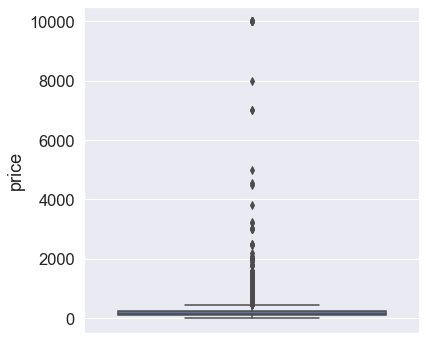

In [307]:
plt.figure(figsize = (6, 6))
sns.boxplot(y = 'price',  data = listings_df)
xt = plt.xticks(rotation=90)

Use the Tukey rule to determine what values of the population data are outliers.

In [308]:
Q1 = listings_df['price'].quantile(0.25)
Q3 = listings_df['price'].quantile(0.75)

IQR = Q3 - Q1
max_value = Q3 + 1.5 * IQR

print("Any listing more than $%d will be discarded" % max_value)

listings_df = listings_df[(listings_df['price'] < max_value)]

Any listing more than $451 will be discarded


In [309]:
amenities = ["Doorman", "Gym", "Pool", "Wheelchair Accessible", "Fireplace", "Air Conditioning"
                 "Washer/Dryer", "TV", "Breakfast", "Dog(s)", "Cat(s)", "'24-Hour Check-in'"]
    

amenity_arr = np.array([listings_df['amenities'].map(lambda amns: amn in amns) for amn in amenities])

listings_df = pd.concat([listings_df, pd.DataFrame(data=amenity_arr.T, columns=amenities)], axis=1)

print(amenity_arr.shape)
print(listings_df.shape)

(10, 7949)
(8540, 102)


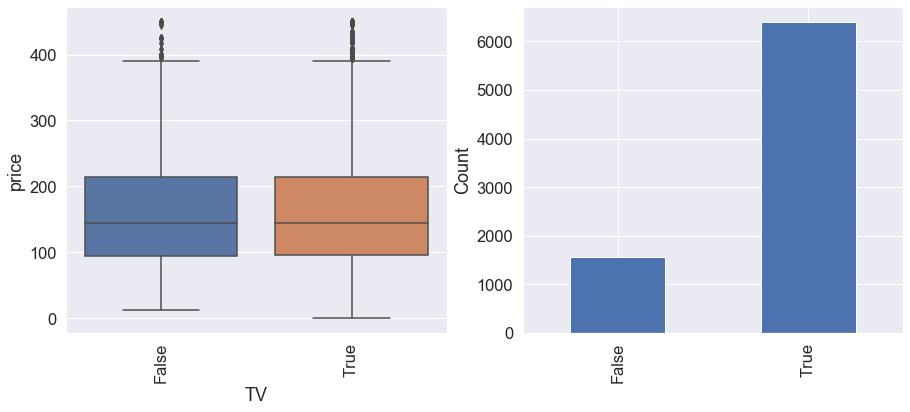

In [310]:
plot_price_dist(listings_df, 'TV')

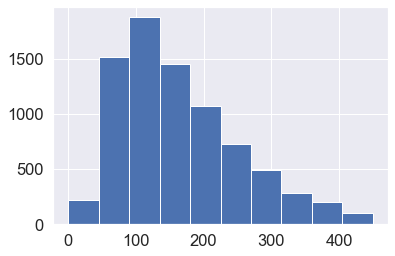

In [169]:
listings_df['price'].hist()

Now lets do a first past to examine how much the features seem to matter in predicting price.

In [288]:
def plot_price_dist(df, col):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    sns.boxplot(x = col, y ='price',  data = df, ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    
    
    listings_df[col].value_counts().sort_index().plot(kind='bar', ax=ax2);
    plt.ylabel("Count");
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

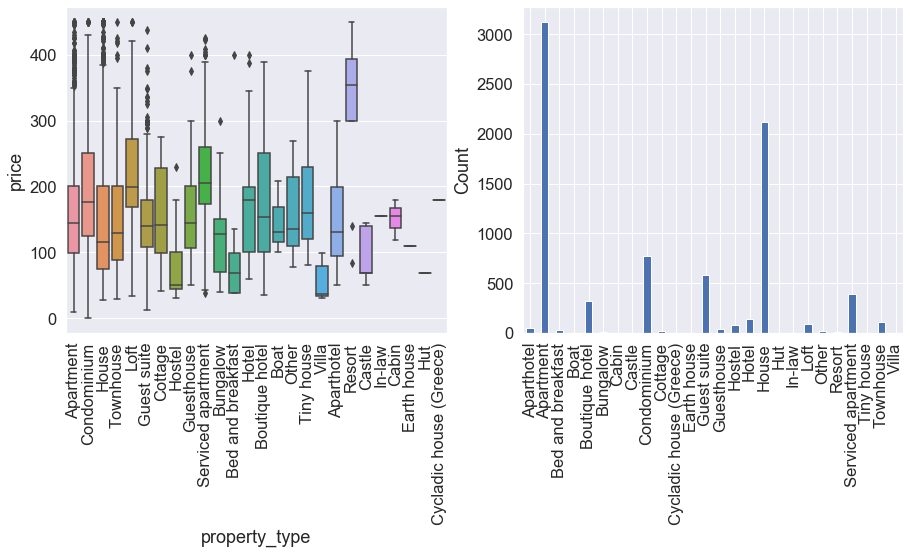

In [250]:
plot_price_dist(listings_df, 'property_type')

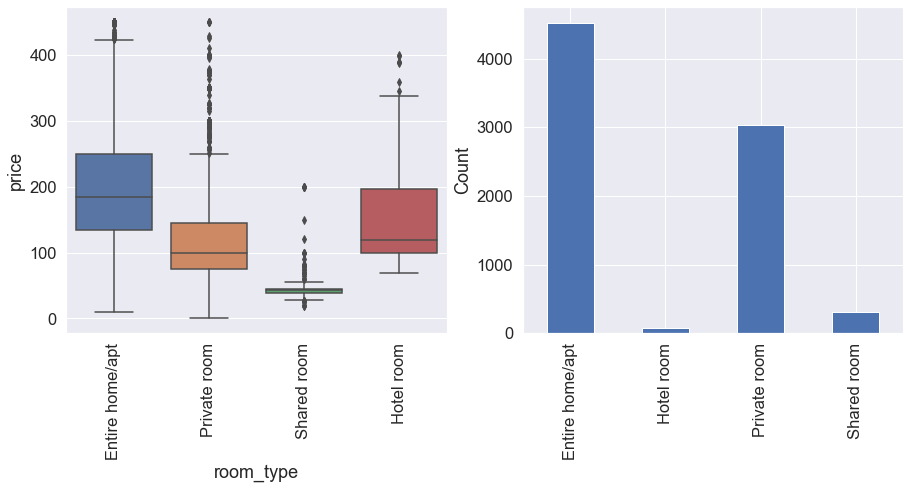

In [172]:
plot_price_dist(listings_df, 'room_type')

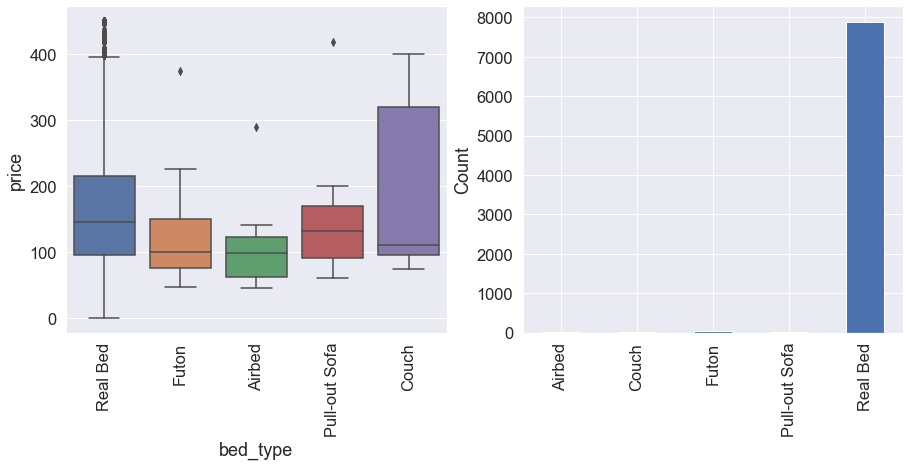

In [173]:
plot_price_dist(listings_df, 'bed_type')

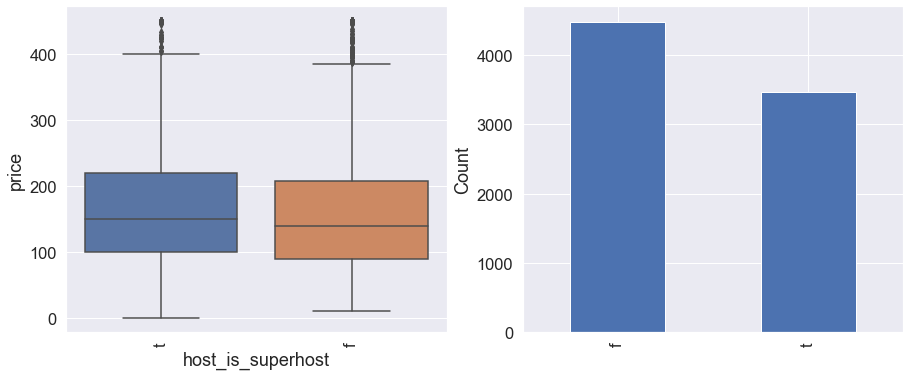

In [174]:
plot_price_dist(listings_df, 'host_is_superhost')

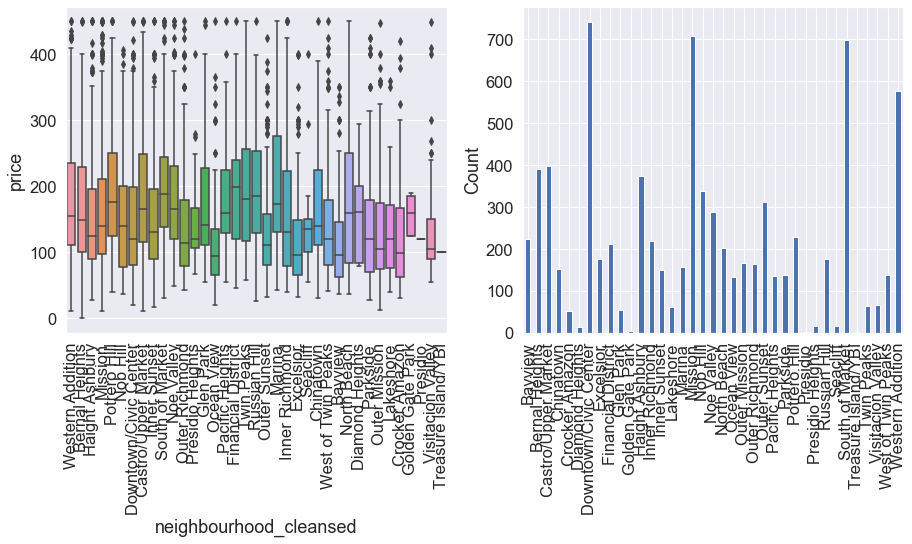

In [175]:
plot_price_dist(listings_df, 'neighbourhood_cleansed')

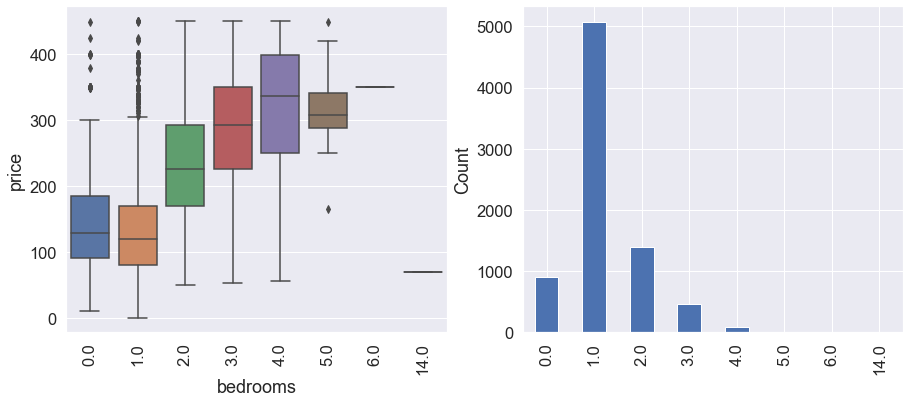

In [176]:
plot_price_dist(listings_df, 'bedrooms')

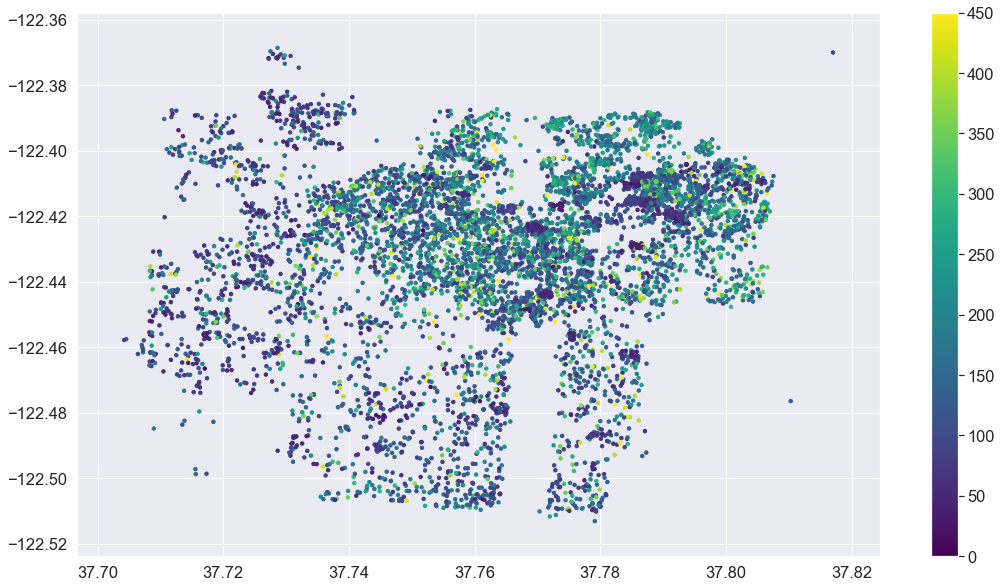

In [208]:
plt.figure(figsize=[18,10])
plt.scatter(listings_df['latitude'], listings_df['longitude'],
            c=price, cmap='viridis',s=12)
cbar = plt.colorbar()

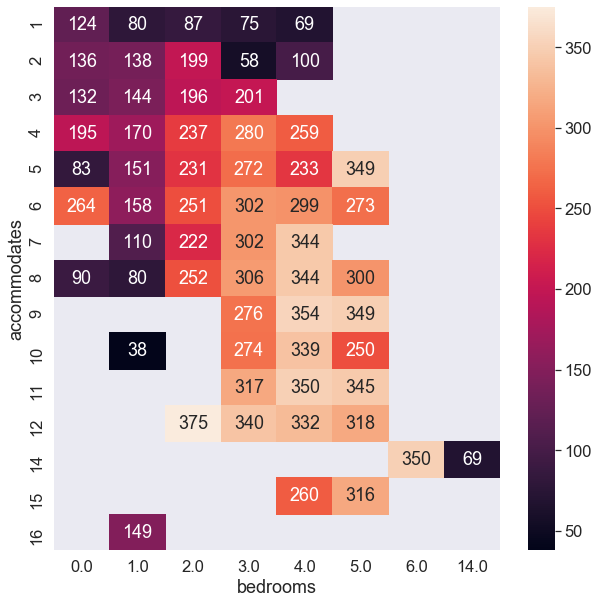

In [178]:
plt.figure(figsize=(10,10))
sns.heatmap(listings_df.groupby([
        'accommodates', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".0f")

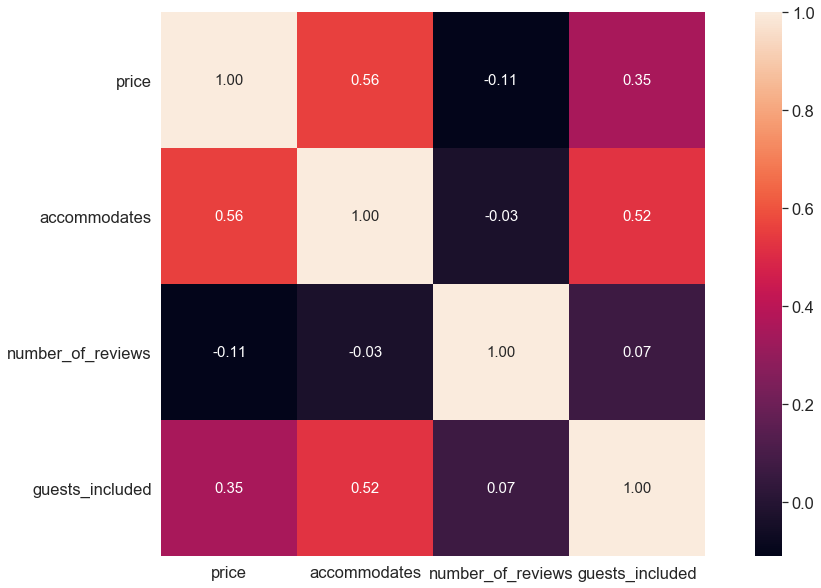

In [211]:
plt.figure(figsize=[18,10])
cols = ['price','accommodates','number_of_reviews', 'guests_included']
cm = np.corrcoef(listings_df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15},
                    yticklabels=cols, xticklabels=cols)
plt.show()

# Data Preparation

In [212]:
features = listings_df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included',
                        'number_of_reviews', 'review_scores_rating']]
price = listings_df['price']

Next add the true/false features and change them from strings to 0 or 1.

In [213]:
tf_cols = ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','instant_bookable',
           'require_guest_profile_picture', 'require_guest_phone_verification']
for col in tf_cols:
    new_feature = listings_df[col].map(lambda s: 0 if s == "f" else 1)
    features.insert(column=col, value=new_feature, loc=0) 

Next I will convert categorical features to dummy features

In [214]:
cat_col = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']
for col in cat_col:
    features = pd.concat([features, pd.get_dummies(listings_df[col], prefix=col[0:5], prefix_sep='_', 
                                                   drop_first=True, dummy_na=True)], axis=1)

In [215]:
# Many features have missing values, but only 1 has the majority missing.
print(features.columns[features.isnull().mean() > 0].shape[0])
print(features.columns[features.isnull().mean() > 0.5])

4
Index([], dtype='object')


So as to not waste this data I will impute the mean.

In [216]:
fill_mean = lambda col: col.fillna(col.mean()) 
features = features.apply(fill_mean, axis=0) 

In [194]:
# Now there are no missing values.
print(features.columns[features.isnull().mean() > 0].shape[0])

0


In [195]:
features.shape

(7949, 85)

## Modeling

In [217]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=.30, random_state=42)

This model does horrible and is greatly overfitting the data.

In [218]:
reg = LinearRegression().fit(X_train, y_train)

In [219]:
reg.score(X_test, y_test)

0.5317169093630125

In [220]:
print(mean_squared_error(reg.predict(X_train), y_train)**0.5)
print(mean_squared_error(reg.predict(X_test), y_test)**0.5)

61.49912929256875
60.43318639187492


In [221]:
print("Start with $%d" % reg.intercept_)
for i, c in enumerate(reg.coef_):
    if c > 1 or c < -1:
        print("$%f for %s" % (c, X_train.columns[i]))

Start with $-62
$1.728590 for require_guest_phone_verification
$-12.658796 for require_guest_profile_picture
$-3.658404 for instant_bookable
$16.265086 for host_has_profile_pic
$7.760068 for host_identity_verified
$9.568734 for host_is_superhost
$14.557795 for accommodates
$-1.925049 for bathrooms
$29.073984 for bedrooms
$-4.133982 for beds
$5.121254 for guests_included
$1.233839 for review_scores_rating
$30.138684 for neigh_Bernal Heights
$58.316058 for neigh_Castro/Upper Market
$58.510592 for neigh_Chinatown
$-1.977434 for neigh_Crocker Amazon
$37.136882 for neigh_Diamond Heights
$46.187427 for neigh_Downtown/Civic Center
$-5.018754 for neigh_Excelsior
$68.467289 for neigh_Financial District
$46.625433 for neigh_Glen Park
$48.835508 for neigh_Golden Gate Park
$48.945420 for neigh_Haight Ashbury
$49.347269 for neigh_Inner Richmond
$36.180698 for neigh_Inner Sunset
$13.993695 for neigh_Lakeshore
$68.344211 for neigh_Marina
$50.905088 for neigh_Mission
$48.347631 for neigh_Nob Hill
$53.

In [222]:
las = Lasso(alpha = 1, max_iter=1000).fit(X_train, y_train)

In [223]:
print(mean_squared_error(las.predict(X_train), y_train)**0.5)
print(mean_squared_error(las.predict(X_test), y_test)**0.5)

65.73755982484964
64.29470720575135


In [224]:
print("Start with $%d" % las.intercept_)
for i, c in enumerate(las.coef_):
    if c > 1 or c < -1:
        print("$%f for %s" % (c, X_train.columns[i]))

Start with $-34
$6.330093 for host_identity_verified
$5.760414 for host_is_superhost
$17.260500 for accommodates
$23.442494 for bedrooms
$-2.254024 for beds
$3.360790 for guests_included
$1.486104 for review_scores_rating
$-1.169871 for neigh_Excelsior
$-1.542088 for neigh_Outer Sunset
$12.204509 for neigh_South of Market
$1.541545 for neigh_Western Addition
$-9.169610 for prope_Apartment
$17.693922 for prope_Boutique hotel
$3.752887 for prope_Condominium
$-14.092269 for prope_Guest suite
$-11.793443 for prope_House
$-41.200336 for room__Private room
$-78.634057 for room__Shared room


Now I want to add a feature that takes into account longitude and latitude. However this data is not linearly separable so a linear regression might struggle.

In [225]:
knn_features = listings_df[['longitude', 'latitude','bedrooms','accommodates']][price < 600]

knn_features = knn_features.apply(fill_mean, axis=0) 

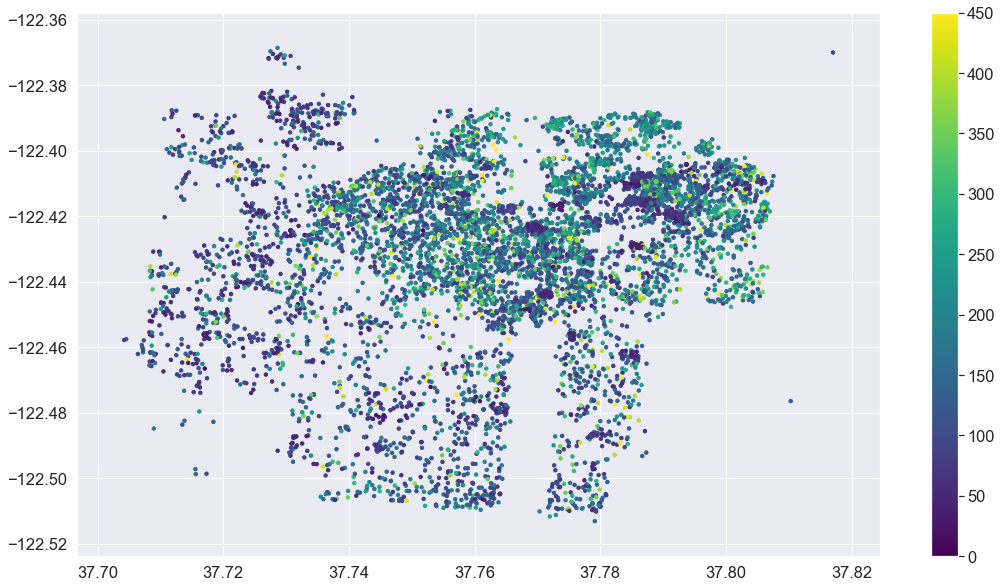

In [226]:
plt.figure(figsize=[18,10])
plt.scatter(knn_features['latitude'], knn_features['longitude'],
            c=price, cmap='viridis',s=12)
cbar = plt.colorbar()

In [229]:
# Split data into training and test data, and fit a linear model
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(knn_features, price, test_size=.30, random_state=42)

In [230]:
neigh = KNeighborsRegressor(n_neighbors=10).fit(X_knn_train, y_train)

In [231]:
print(mean_squared_error(neigh.predict(X_knn_train), y_train)**0.5)
print(mean_squared_error(neigh.predict(X_knn_test), y_test)**0.5)

57.73241762901634
63.344337144041766


In [232]:
X_train['knn'] = neigh.predict(X_knn_train)
X_test['knn'] = neigh.predict(X_knn_test)

/Users/andrewblaikie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/andrewblaikie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [237]:
reg2 = LinearRegression().fit(X_train, y_train)

In [238]:
print(mean_squared_error(reg2.predict(X_train), y_train)**0.5)
print(mean_squared_error(reg2.predict(X_test), y_test)**0.5)

54.848084498900626
59.5219473077157


In [239]:
print("Start with $%d" % reg2.intercept_)
for i, c in enumerate(reg2.coef_):
    if c > 0.1 or c < -0.1:
        print("$%f for %s" % (c, X_train.columns[i]))

Start with $-23
$-4.166038 for require_guest_phone_verification
$-3.857806 for require_guest_profile_picture
$-4.422123 for instant_bookable
$-17.498061 for host_has_profile_pic
$4.258728 for host_identity_verified
$6.274285 for host_is_superhost
$-1.335255 for accommodates
$4.096255 for bedrooms
$-2.337159 for beds
$3.844423 for guests_included
$0.788721 for review_scores_rating
$8.608829 for neigh_Bernal Heights
$13.796421 for neigh_Castro/Upper Market
$8.159512 for neigh_Chinatown
$-5.783485 for neigh_Crocker Amazon
$-2.144872 for neigh_Diamond Heights
$7.883172 for neigh_Downtown/Civic Center
$0.828133 for neigh_Excelsior
$5.827276 for neigh_Financial District
$19.549230 for neigh_Glen Park
$-4.329672 for neigh_Golden Gate Park
$17.337347 for neigh_Haight Ashbury
$22.210745 for neigh_Inner Richmond
$14.218156 for neigh_Inner Sunset
$11.761642 for neigh_Lakeshore
$16.949156 for neigh_Marina
$14.987185 for neigh_Mission
$12.155705 for neigh_Nob Hill
$13.555263 for neigh_Noe Valley
$2

Can a nonlinear regressor do better? Yes, they have lower mean squared errors on the test set, but are more clearly overfitting.

In [240]:
forest = RandomForestRegressor(n_estimators=200).fit(X_train, y_train)

In [241]:
print(mean_squared_error(forest.predict(X_train), y_train)**0.5)
print(mean_squared_error(forest.predict(X_test), y_test)**0.5)

20.66969921758914
57.550789970853785


In [242]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(10):
    print("The number %d most important feature is %s" % (i+1, X_train.columns[indices[i]]))

The number 1 most important feature is knn
The number 2 most important feature is number_of_reviews
The number 3 most important feature is review_scores_rating
The number 4 most important feature is guests_included
The number 5 most important feature is bathrooms
The number 6 most important feature is accommodates
The number 7 most important feature is room__Private room
The number 8 most important feature is beds
The number 9 most important feature is bedrooms
The number 10 most important feature is room__Shared room


In [243]:
mlp = MLPRegressor(activation='relu',max_iter=2000, hidden_layer_sizes=(10,5)).fit(X_train, y_train)

In [244]:
mlp.score(X_test, y_test)

0.5484247997363014

In [245]:
print(mean_squared_error(mlp.predict(X_train), y_train)**0.5)
print(mean_squared_error(mlp.predict(X_test), y_test)**0.5)

54.297106741099896
59.34529554375224


# Summary